In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.pipeline import Pipeline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.decomposition import PCA
from pprint import pprint
from sklearn.ensemble import VotingClassifier

%matplotlib inline

# The data

In [2]:
medical_orig = pd.read_csv('medical.csv', index_col='AppointmentID', parse_dates=[3, 4])
medical_orig.drop('PatientId', axis=1, inplace=True)
# medical_orig.head()

## Inspection and preparation

Here we make preparations that are NOT part of the processing pipeline.

In [3]:
medical_orig.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110527 entries, 5642903 to 5629448
Data columns (total 12 columns):
Gender            110527 non-null object
ScheduledDay      110527 non-null datetime64[ns]
AppointmentDay    110527 non-null datetime64[ns]
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: datetime64[ns](2), int64(7), object(3)
memory usage: 11.0+ MB


In [4]:
# medical_orig.describe()

Extracting useful (hopefully) information

In [5]:
medical_orig['ScheduledHour'] = medical_orig['ScheduledDay'].dt.hour
medical_orig['AwaitingTime'] = (medical_orig['AppointmentDay'] - \
                                medical_orig['ScheduledDay']).dt.days + 1
medical_orig.drop('ScheduledDay', axis=1, inplace=True)

> **NOTE:** _ScheduledHour_ is the hour of **scheduling** and not the hour of the appointment.

In [6]:
medical_orig['Weekday'] = medical_orig['AppointmentDay'].dt.dayofweek
medical_orig['Month'] = medical_orig['AppointmentDay'].dt.month
medical_orig.drop('AppointmentDay', axis=1, inplace=True)

In [7]:
medical_orig.drop('Neighbourhood', axis=1, inplace=True)

> **NOTE:** _Neighbourhood_ is actually a potentially useful feature, but we drop it in favor of simplifying this demo.

In [8]:
medical_orig.Handcap.value_counts()
medical_orig.drop('Handcap', axis=1, inplace=True)

> **NOTE:** We decide to drop _Handcap_ since it is mostly 0, and also it looks irrelevant for the target. Run _pd.pivot_\__table(data=medical, index='Handcap', columns='No-show', values='Gender', aggfunc='count')_ to convince yourself. This is where we should consider dimentionality reduction tools.

Removing infeasible data

In [9]:
medical_orig = medical_orig[medical_orig.AwaitingTime >= 0]
medical_orig = medical_orig[medical_orig.Age >= 0]

Current status...

In [10]:
# medical_orig.head()

> **NOTE:** There are still some categorical columns (e.g. _Age_, _Handcap_, etc.), but they have numerical values, so we deal with them later. The following _nunique()_ application clears it.

In [11]:
medical_orig.apply(pd.Series.nunique)

Gender             2
Age              103
Scholarship        2
Hipertension       2
Diabetes           2
Alcoholism         2
SMS_received       2
No-show            2
ScheduledHour     16
AwaitingTime     129
Weekday            6
Month              3
dtype: int64

## Assessment

### Imbalanced sizes

We note that one of the classes ('Yes') is much more rare. We will use the _class_\__weight_ argument to mitigate this issue.

In [12]:
no_shows = medical_orig['No-show'].value_counts()
no_shows

No     88207
Yes    22314
Name: No-show, dtype: int64

### Imbalanced importances

We consider 'Yes' to be the positive label, i.e. patients who did _not_ show to their appointment. The business scenario we may consider is that the clinic would like to contact patients who are likely to not show and remind them about the appointment. In this scenario, since calling is rather cheap comparing with the financial loss of missing an appointment, a clinic may prefer to call even patients with lower chances of missing their appointment. This means that in this business scenario **recall is more importanty than precision**, and we would like our score to reflect that.

### $F_{\beta}$

$F_{\beta}$ is exactly such a measure. It exposes a parameter $\beta$ which allows to specify which class is more important. In a nutshell, it follows the logic below:

* $\beta < 1$ - precision is more important
* $\beta > 1$ - recall is more important

To illustrate how it works, let's consider two models with **results we consider to be equivalent business-wise** and see how the selection of $\beta$ controls which is preferred. Without being too precise, we take one model with $r=0.9$ (recall) and $p=0.4$ and a second model with $r=0.8$ (recall) and $p=0.7$, .

In [13]:
betas = pd.Series(np.linspace(1, 10, 30))

In [14]:
def calc_fbeta(b, p, r):
    return (1 + b**2) * r * p / (b**2*p + r)

In [15]:
Fb = pd.DataFrame({'Beta': betas,
                   'Model1': betas.apply(calc_fbeta, r=0.9, p=0.4),
                   'Model2': betas.apply(calc_fbeta, r=0.8, p=0.7)})
Fb.head()

,Beta,Model1,Model2
0,1.000000,0.553846,0.746667
1,1.310345,0.616411,0.760038
2,1.620690,0.669308,0.769681
3,1.931034,0.711838,0.776541
4,2.241379,0.745335,0.781467


Thus the required $\beta$ is...

In [16]:
best_beta_ind = (Fb.Model1 - Fb.Model2).abs().idxmin()
my_beta = Fb.Beta[best_beta_ind]
print my_beta

2.86206896552


#### Illustration 1

The $F_{\beta}$ score of the "just-say-yes" classifier can be calculated as follows.

In [17]:
precision = float(no_shows['Yes'])/(no_shows['Yes'] + no_shows['No'])
precision

0.20189828177450439

In [18]:
recall = 1.0

In [19]:
calc_fbeta(my_beta, precision, recall)

0.69926502854284978

This value will be our benchmark.

#### Illustration 2

Using the [_plot_\__surface()_ example from the gallery][surface]

[surface]: https://matplotlib.org/examples/mplot3d/surface3d_demo.html "plot_surface example"

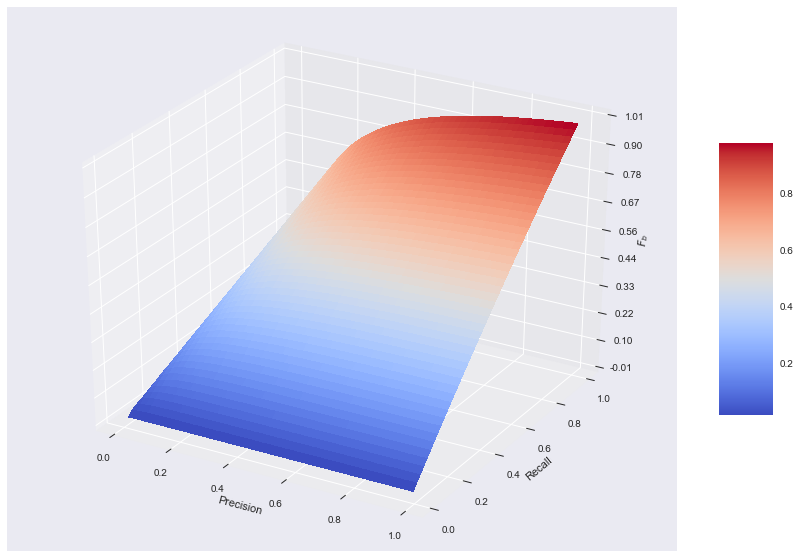

In [20]:
fig = plt.figure(figsize=(15, 10))
ax = fig.gca(projection='3d')

# Make data.
precision = np.arange(0.01, 1, 0.01)
recall = np.arange(0.01, 1, 0.01)
P, R = np.meshgrid(precision, recall)
b=my_beta
Z = (1+b**2)*(P*R)/(b**2*P + R)

# Plot the surface.
surf = ax.plot_surface(P, R, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_zlabel('$F_b$')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

## Visualization

### Age

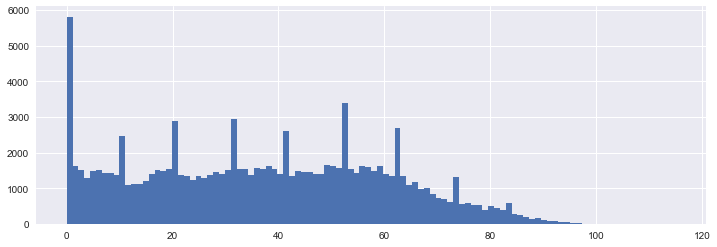

In [21]:
medical_orig['Age'].hist(bins=medical_orig.Age.nunique()+1, figsize=(12, 4))

> **NOTE:** The peaks in the Age histogram are the result of combined bins and should be ignored. To verify this, one can increase the _bins_ value.

### AwaitingTime

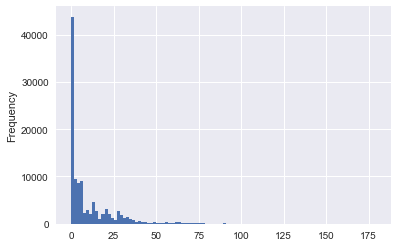

In [22]:
medical_orig.AwaitingTime.plot.hist(bins=100)

Let's zoom-in without the out-of-proportion 0 and the long tail.

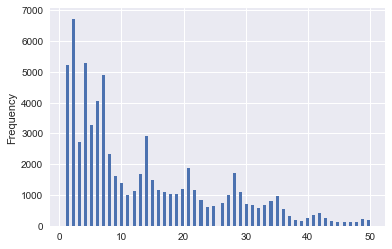

In [23]:
medical_orig.AwaitingTime.plot.hist(bins=100, range=(1, 50))

It looks like there are peaks around full-weeks-ahead scheduling. My assumption is that this is a result of scheduling made at the end of a current appointment. Let's see if this has any influence on the yes-to-no ratio.

In [24]:
AT_full_weeks = medical_orig[(medical_orig.AwaitingTime).isin([7, 14, 21, 28])]
yn = AT_full_weeks.groupby('No-show')['Gender'].count()
print float(yn['Yes']) / yn['No']

0.408112787534


**YES.** This means we should definitely create a new column with the relevant information.

In [25]:
medical_orig['follow-up'] = medical_orig.AwaitingTime.isin([7, 14, 21, 28]).astype(int)

### ScheduledHour

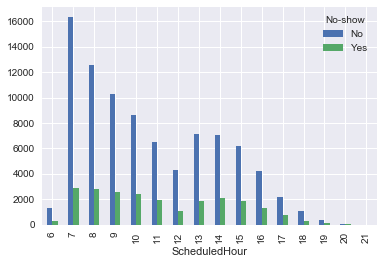

In [26]:
pt = pd.pivot_table(data=medical_orig, 
                    index='ScheduledHour', 
                    columns='No-show', 
                    values='Gender', 
                    aggfunc='count')
pt.plot.bar()

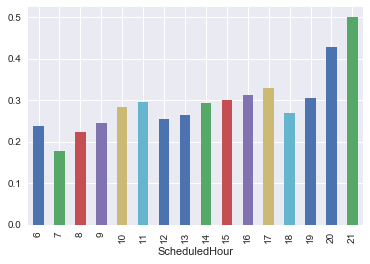

In [27]:
yn = medical_orig.groupby(['ScheduledHour','No-show'])['Gender'].count().unstack()
yn['ratio'] = yn['Yes'] / yn['No']
yn['ratio'].plot.bar()

### Weekday

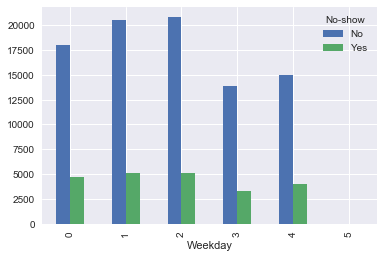

In [28]:
pt = pd.pivot_table(data=medical_orig, 
                    index='Weekday', 
                    columns='No-show', 
                    values='Gender', 
                    aggfunc='count')
pt.plot.bar()

### Month

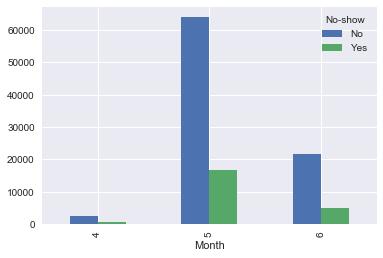

In [29]:
pt = pd.pivot_table(data=medical_orig, 
                    index='Month', 
                    columns='No-show', 
                    values='Gender', 
                    aggfunc='count')
pt.plot.bar()

It seems the month has no significant influence, so we drop it.

In [30]:
medical_orig.drop('Month', axis=1, inplace=True)

### Saving the prepared data

The process above is a preparation of the data so that it is more convenient to apply machine learning algorithms to. We therefore save it for future steps.

In [31]:
medical_orig.to_csv('medical_prep.csv')

## Preprocessing

In [32]:
medical_prep = pd.read_csv('medical_prep.csv', index_col='AppointmentID')
# medical_prep.head()

> **NOTE:** **_medical_\__prep_** refers to the data _prior_ to the pipeline. In other words, it is the input to the pipeline.

### Binned data

In [33]:
class Digitizer(BaseEstimator, TransformerMixin):
    def __init__(self, colname, bins):
        self.colname = colname
        self.bins = bins
    def fit(self, X, y=None):
        self.labels = ['{}-{}'.format(low, high) 
                       for low, high in zip(self.bins[:-1], self.bins[1:])]        
        return self
    def transform(self, X, y=None):    
        X_copy = X.copy()
        binned = pd.cut(X_copy[self.colname], 
                        bins=self.bins, 
                        labels=self.labels, 
                        include_lowest=True)
        X_copy[self.colname] = binned.astype(str)
        return X_copy

> **WARNING:** _self.labels_ must be evaluated within the _fit()_ method and **not** within the \_\_init\_\_() method.

In [34]:
age_digitizer = Digitizer('Age', [0, 0.01, 2, 6, 15, 30, 60, 120])
scheduled_hour_digitizer = Digitizer('ScheduledHour', [10, 13, 17, 20])
awaiting_time_digitizer = Digitizer('AwaitingTime', [0, 1, 7, 30, 99999])

In [35]:
digitizer_pipeline = \
    Pipeline([('scheduled_hour_digitizer', scheduled_hour_digitizer),
              ('awaiting_time_digitizer', awaiting_time_digitizer), 
              ('age_digitizer', age_digitizer)])

In [36]:
# digitizer_pipeline.fit_transform(medical_prep).head()

### Categorical data

In [37]:
class Binarizer(BaseEstimator, TransformerMixin):
    def __init__(self, colname, drop_first):
        self.colname = colname
        self.drop_first = drop_first
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        dummies = pd.get_dummies(X[self.colname], 
                                 prefix=self.colname, 
                                 columns=[self.colname], 
                                 drop_first=self.drop_first)
        X_no_col = X.drop(self.colname, axis=1, inplace=False)
        X_with_dummies = X_no_col.join(dummies)
        return X_with_dummies

In [38]:
gender_binarizer = Binarizer(colname='Gender', drop_first=True)
weekday_binarizer = Binarizer(colname='Weekday', drop_first=False)

**Illustration**

In [39]:
binarizer_pipeline_1 = \
    Pipeline([('gender_binarizer', gender_binarizer), 
              ('weekday_binarizer', weekday_binarizer)])

In [40]:
# binarizer_pipeline_1.fit_transform(medical_prep).head()

After digitization, the digitized columns are also categorical, therefore we can apply our binarizer.

In [41]:
age_binarizer = Binarizer(colname='Age', drop_first=False)
scheduled_hour_binarizer = Binarizer(colname='ScheduledHour', drop_first=False)
awaiting_time_binarizer = Binarizer(colname='AwaitingTime', drop_first=False)

In [42]:
binarizer_pipeline_2 = \
    Pipeline([('age_binarizer', age_binarizer),
              ('scheduled_hour_binarizer', scheduled_hour_binarizer), 
              ('awaiting_time_binarizer', awaiting_time_binarizer)])

In [43]:
# binarizer_pipeline_2.fit_transform(medical_prep).head()

## Final transformation

In [44]:
transformer_pipeline = \
    Pipeline([('digitizer_pipeline', digitizer_pipeline), 
              ('binarizer_pipeline_1', binarizer_pipeline_1), 
              ('binarizer_pipeline_2', binarizer_pipeline_2)])

**Illustration**

In [45]:
# transformer_pipeline.fit_transform(medical_prep).head()

# Modelling

In [46]:
medical_prep = pd.read_csv('medical_prep.csv', index_col='AppointmentID')
# medical_prep.head()

In [47]:
X_train, X_test, y_train, y_test = \
    train_test_split(medical_prep.drop('No-show', axis=1), medical_prep['No-show'], 
                     train_size=0.7, test_size=0.3, random_state=1234)

## Logistic regression

### Preliminary illustration

For the illustration we transform **_medical_\__prep_** into **_medical_**. This is usually not necessary because we have the pipeline.

In [48]:
medical = transformer_pipeline.fit_transform(medical_prep)
X_train, X_test, y_train, y_test = \
    train_test_split(medical.drop('No-show', axis=1), medical['No-show'], 
                     train_size=0.7, test_size=0.3, random_state=1234)

In [49]:
lr_clf = LogisticRegression(C=1.0, class_weight='balanced')

In [50]:
y_pred = lr_clf.fit(X_train, y_train).predict(X_train)

In [51]:
cmat = confusion_matrix(y_true=y_train, 
                        y_pred=y_pred, 
                        labels=lr_clf.classes_)
pd.DataFrame(cmat, 
             index=lr_clf.classes_, 
             columns=lr_clf.classes_)

,No,Yes
No,32571,29142
Yes,2943,12708


In [52]:
calc_fbeta(my_beta, p=12971.0/(12971+30172), r=12971.0/(12971+2680))

0.695792791325749

#### Cross validation

Since _fbeta_\__score()_ requires a parameter ($\beta$), we must define a proper _Scorer_ before we apply it to the cross-validation scheme.

In [53]:
my_fbeta_score = \
    make_scorer(fbeta_score, beta=my_beta, pos_label='Yes', greater_is_better=True)

> **WARNING:** The _scoring_ argument of _cross_\__val_\__score()_ assumes the scoring method is equivalent to the error (like for regression). Here the opposite is the case. More details can be found [here][scorer].

[scorer]: http://scikit-learn.org/stable/modules/model_evaluation.html#scoring "scoring"

In [54]:
def show_cv_summary(scores):
    print 'Scores:', scores
    print 'Mean:', scores.mean()
    print 'Std:', scores.std()

In [55]:
scores = cross_val_score(lr_clf, X_train, y_train, scoring=my_fbeta_score, cv=10)
show_cv_summary(scores)

Scores: [ 0.68848538  0.69905918  0.68154553  0.68667694  0.68903604  0.68595233
  0.68693416  0.67994098  0.68257782  0.69213928]
Mean: 0.687234764051
Std: 0.00527237827539


> **NOTE:** The default cross-validation scheme is _StratifiedKFold_, which is a good choice in our case.

Thus, our first model is valid, but not very useful, as its score is lower than the benchmark.

#### Simple grid search

In [56]:
param_grid = {'C': [0.1, 0.2, 0.5, 1.0, 2.0, 5.0]}
lr_gs = GridSearchCV(lr_clf, param_grid=param_grid, scoring=my_fbeta_score)
lr_gs.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 0.2, 0.5, 1.0, 2.0, 5.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(fbeta_score, beta=2.86206896552, pos_label=Yes),
       verbose=0)

> **NOTE:** Fitting the _GridSearchCV_ object means fitting multiple models. This may take a while. Be careful.

In [57]:
lr_gs_clf = lr_gs.best_estimator_
lr_gs_clf

LogisticRegression(C=2.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [58]:
y_pred = lr_gs_clf.fit(X_train, y_train).predict(X_train)

In [59]:
cmat = confusion_matrix(y_true=y_train, 
                        y_pred=y_pred, 
                        labels=lr_gs_clf.classes_)
pd.DataFrame(cmat, 
             index=lr_gs_clf.classes_, 
             columns=lr_gs_clf.classes_)

,No,Yes
No,32571,29142
Yes,2943,12708


And looking at the score we see there is no improvement.

In [60]:
fbeta_score( y_true=y_train, y_pred=y_pred, beta=my_beta, pos_label='Yes')

0.6868680588379773

Simple grid-search didn't improve the model...

### Using the pipeline

> **NOTE:** Going back to use **_medical_\__prep_** (instead of **_medical_**).

In [61]:
X_train, X_test, y_train, y_test = \
    train_test_split(medical_prep.drop('No-show', axis=1), medical_prep['No-show'], 
                     train_size=0.7, test_size=0.3, random_state=1234)

#### Simple illustration

In [62]:
lr_pipeline = Pipeline([('transformer_pipeline', transformer_pipeline), 
                        ('lr_clf', lr_clf)])

In [63]:
# sorted(lr_pipeline.get_params().keys())

In [64]:
lr_pipeline.set_params(transformer_pipeline__digitizer_pipeline__age_digitizer__bins=[0, 3, 15, 60, 120])

Pipeline(memory=None,
     steps=[('transformer_pipeline', Pipeline(memory=None,
     steps=[('digitizer_pipeline', Pipeline(memory=None,
     steps=[('scheduled_hour_digitizer', Digitizer(bins=[5, 10, 15, 23], colname='ScheduledHour')), ('awaiting_time_digitizer', Digitizer(bins=[0, 1, 7, 30, 99999], colname='AwaitingTime'))...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [65]:
scores = cross_val_score(lr_pipeline, X_train, y_train, scoring=my_fbeta_score, cv=10)
show_cv_summary(scores)

Scores: [ 0.69876023  0.70286896  0.69874607  0.69683232  0.69311107  0.6921328
  0.69581014  0.69024822  0.68824828  0.69380041]
Mean: 0.695055849713
Std: 0.00418889470148


#### Grid search

In [66]:
param_grid = \
    {'transformer_pipeline__digitizer_pipeline__age_digitizer__bins': 
     [[0, 1, 6, 18, 120], [0, 1, 6, 120], [0, 6, 18, 120], [0, 1, 18, 120]],
     'transformer_pipeline__digitizer_pipeline__awaiting_time_digitizer__bins': 
     [[0, 1, 7, 99999], [0, 1, 14, 99999], [0, 1, 30, 99999], [0, 1, 7, 30, 99999]]}

In [67]:
lr_gs = GridSearchCV(lr_pipeline, param_grid=param_grid, scoring=my_fbeta_score, cv=3)
lr_gs.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('transformer_pipeline', Pipeline(memory=None,
     steps=[('digitizer_pipeline', Pipeline(memory=None,
     steps=[('scheduled_hour_digitizer', Digitizer(bins=[5, 10, 15, 23], colname='ScheduledHour')), ('awaiting_time_digitizer', Digitizer(bins=[0, 1, 7, 30, 99999], colname='AwaitingTime'))...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'transformer_pipeline__digitizer_pipeline__age_digitizer__bins': [[0, 1, 6, 18, 120], [0, 1, 6, 120], [0, 6, 18, 120], [0, 1, 18, 120]], 'transformer_pipeline__digitizer_pipeline__awaiting_time_digitizer__bins': [[0, 1, 7, 99999], [0, 1, 14, 99999], [0, 1, 30, 99999], [0, 1, 7, 30, 99999]]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(fbeta_score, beta=2.86206896552, pos_label=Yes),
       

> **WARNING:** The line above fits $4\times 4\times 3=48$ models, and this number can easily be increased. Be careful... 

In [68]:
# pprint(lr_gs.cv_results_)

In [69]:
lr_gs_clf = lr_gs.best_estimator_
lr_gs_clf

Pipeline(memory=None,
     steps=[('transformer_pipeline', Pipeline(memory=None,
     steps=[('digitizer_pipeline', Pipeline(memory=None,
     steps=[('scheduled_hour_digitizer', Digitizer(bins=[5, 10, 15, 23], colname='ScheduledHour')), ('awaiting_time_digitizer', Digitizer(bins=[0, 1, 30, 99999], colname='AwaitingTime')), (...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

> **NOTE 1:** Since _refit=True_ by default, the attribute _best_\__estimator_\_ is holding a model which was fit to the entire _X_\__train_.

> **NOTE 2:** The result of the grid search (_lr_\__gs_\__clf_) is not an estimator but a pipeline.

In [70]:
y_pred = lr_gs_clf.fit(X_train, y_train).predict(X_train)

In [71]:
cmat = confusion_matrix(y_true=y_train, y_pred=y_pred, labels=lr_gs_clf.classes_)
pd.DataFrame(cmat, index=lr_gs_clf.classes_, columns=lr_gs_clf.classes_)

,No,Yes
No,28999,32714
Yes,2102,13549


In [72]:
fbeta_score(y_true=y_train, y_pred=y_pred, beta=my_beta, pos_label='Yes')

0.71380063435120644

The grid search improved our score :-)

## Decision tree

### Preliminary illustration

Again - for the illustration we transform **_medical_\__prep_** into **_medical_**.

In [73]:
medical = transformer_pipeline.fit_transform(medical_prep)
X_train, X_test, y_train, y_test = \
    train_test_split(medical.drop('No-show', axis=1), medical['No-show'], 
                     train_size=0.7, test_size=0.3, random_state=1234)

In [74]:
dt_clf = DecisionTreeClassifier(max_depth=None,
                                min_samples_split=100,
                                min_samples_leaf=10, 
                                class_weight='balanced')

> **NOTE:** Don't forget the _class_\__weight_ argument...

In [75]:
y_pred = dt_clf.fit(X_train, y_train).predict(X_train)

In [76]:
cmat = confusion_matrix(y_true=y_train, 
                        y_pred=y_pred, 
                        labels=dt_clf.classes_)
pd.DataFrame(cmat, 
             index=dt_clf.classes_, 
             columns=dt_clf.classes_)

,No,Yes
No,35214,26499
Yes,3131,12520


In [77]:
calc_fbeta(my_beta, p=12520.0/(12520+26499), r=12520.0/(12520+3131))

0.68816293285417618

#### Cross validation

In [78]:
scores = cross_val_score(dt_clf, X_train, y_train, scoring=my_fbeta_score, cv=10)
show_cv_summary(scores)

Scores: [ 0.66264812  0.67352426  0.66148753  0.65489737  0.66974391  0.66187836
  0.65224758  0.64006609  0.65082422  0.66368708]
Mean: 0.659100451352
Std: 0.009294073332


#### Simple grid search

In [79]:
param_grid = {'max_depth': range(2, 9, 2), 
              'min_samples_split': range(20, 200, 50), 
              'min_samples_leaf': range(10, 51, 10)}
dt_gs = GridSearchCV(dt_clf, param_grid=param_grid, scoring=my_fbeta_score, cv=3)
dt_gs.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=100,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [20, 70, 120, 170], 'max_depth': [2, 4, 6, 8], 'min_samples_leaf': [10, 20, 30, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(fbeta_score, beta=2.86206896552, pos_label=Yes),
       verbose=0)

> **NOTE:** This simple grid search has $5 \times 4 \times 5 \times 3=300$ models...

In [80]:
dt_gs_clf = dt_gs.best_estimator_
dt_gs_clf

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=20,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [81]:
y_pred = dt_gs_clf.fit(X_train, y_train).predict(X_train)

In [82]:
cmat = confusion_matrix(y_true=y_train, 
                        y_pred=y_pred, 
                        labels=dt_gs_clf.classes_)
pd.DataFrame(cmat, 
             index=dt_gs_clf.classes_, 
             columns=dt_gs_clf.classes_)

,No,Yes
No,28589,33124
Yes,2004,13647


And looking at the score we see there is no improvement.

In [83]:
fbeta_score(y_true=y_train, y_pred=y_pred, beta=my_beta, pos_label='Yes')

0.71687621450023664

Simple grid-search gave us the best model so far...

#### Visualization

In [84]:
export_graphviz(dt_gs_clf, 
                out_file='tree1.dot', 
                feature_names=X_train.columns,
                class_names=dt_clf.classes_, 
                filled=True, 
                leaves_parallel=True, 
                rotate=False, 
                rounded=True)

In [85]:
d_importances = dict(zip(X_train.columns, dt_gs_clf.feature_importances_))
sorted(d_importances.items(), key=lambda item: item[1], reverse=True)

[('AwaitingTime_0-1', 0.93914270560663127),
 ('Age_60-120', 0.046322106140606743),
 ('Weekday_0', 0.014535188252761904),
 ('Weekday_2', 0.0),
 ('Weekday_3', 0.0),
 ('Weekday_1', 0.0),
 ('Hipertension', 0.0),
 ('Weekday_4', 0.0),
 ('Weekday_5', 0.0),
 ('ScheduledHour_10-15', 0.0),
 ('Gender_M', 0.0),
 ('follow-up', 0.0),
 ('Age_15-60', 0.0),
 ('Alcoholism', 0.0),
 ('ScheduledHour_15-23', 0.0),
 ('ScheduledHour_5-10', 0.0),
 ('AwaitingTime_30-99999', 0.0),
 ('Diabetes', 0.0),
 ('Scholarship', 0.0),
 ('AwaitingTime_1-7', 0.0),
 ('AwaitingTime_7-30', 0.0),
 ('SMS_received', 0.0),
 ('Age_3-15', 0.0),
 ('Age_0-3', 0.0)]

### Using the pipeline

> **NOTE:** Again - we are going back to use **_medical_\__prep_** (instead of **_medical_**).

In [86]:
X_train, X_test, y_train, y_test = \
    train_test_split(medical_prep.drop('No-show', axis=1), medical_prep['No-show'], 
                     train_size=0.7, test_size=0.3, random_state=1234)

In [87]:
dt_pipeline = Pipeline([('transformer_pipeline', transformer_pipeline), 
                        ('dt_clf', dt_clf)])

In [88]:
# sorted(dt_pipeline.get_params().keys())

In [89]:
scores = cross_val_score(dt_pipeline, X_train, y_train, scoring=my_fbeta_score, cv=10)
show_cv_summary(scores)

Scores: [ 0.66264812  0.67352426  0.66089911  0.65489737  0.66974391  0.66187836
  0.65224758  0.64006609  0.65082422  0.66368708]
Mean: 0.659041608948
Std: 0.00928062702904


#### Grid search

In [90]:
param_grid = \
    {'transformer_pipeline__digitizer_pipeline__age_digitizer__bins': 
     [[0, 1, 6, 18, 120], [0, 1, 6, 120], [0, 6, 18, 120], [0, 1, 18, 120]],
     'transformer_pipeline__digitizer_pipeline__awaiting_time_digitizer__bins': 
     [[0, 1, 7, 99999], [0, 1, 14, 99999], [0, 1, 30, 99999], [0, 1, 7, 30, 99999]],
     'dt_clf__max_depth': [2], 
     'dt_clf__min_samples_split': [20], 
     'dt_clf__min_samples_leaf': [10]}

> **NOTE 1:** We can't apply the result of the previous grid search, because the decision tree may use the data differently.

> **NOTE 2:** In general we can reduce the size of the grid by "zooming-in" on the values from the simple grid search. After the reducion we are left with $4\times 4\times 1\times 1\times 1\times 3=384$ models. It is advised to "open" the grid again for the classifier hyper-parameters, but we skip it in this tutorial, because it results in a prohibitive number of models.

In [91]:
dt_gs = GridSearchCV(dt_pipeline, param_grid=param_grid, scoring=my_fbeta_score, cv=3)
dt_gs.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('transformer_pipeline', Pipeline(memory=None,
     steps=[('digitizer_pipeline', Pipeline(memory=None,
     steps=[('scheduled_hour_digitizer', Digitizer(bins=[5, 10, 15, 23], colname='ScheduledHour')), ('awaiting_time_digitizer', Digitizer(bins=[0, 1, 7, 30, 99999], colname='AwaitingTime'))...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'transformer_pipeline__digitizer_pipeline__age_digitizer__bins': [[0, 1, 6, 18, 120], [0, 1, 6, 120], [0, 6, 18, 120], [0, 1, 18, 120]], 'dt_clf__min_samples_split': [20], 'dt_clf__max_depth': [2], 'transformer_pipeline__digitizer_pipeline__awaiting_time_digitizer__bins': [[0, 1, 7, 99999], [0, 1, 14, 99999], [0, 1, 30, 99999], [0, 1, 7, 30, 99999]], 'dt_clf__min_samples_leaf': [10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_sc

In [92]:
# pprint(dt_gs.cv_results_)

In [93]:
dt_gs_clf = dt_gs.best_estimator_
dt_gs_clf

Pipeline(memory=None,
     steps=[('transformer_pipeline', Pipeline(memory=None,
     steps=[('digitizer_pipeline', Pipeline(memory=None,
     steps=[('scheduled_hour_digitizer', Digitizer(bins=[5, 10, 15, 23], colname='ScheduledHour')), ('awaiting_time_digitizer', Digitizer(bins=[0, 1, 7, 99999], colname='AwaitingTime')), ('...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])

We shouldn't forget we must validate the 

In [94]:
scores = cross_val_score(dt_gs_clf, X_train, y_train, scoring=my_fbeta_score, cv=10)
show_cv_summary(scores)

Scores: [ 0.72151542  0.73200837  0.7200782   0.71512764  0.71481831  0.7135069
  0.72356661  0.71361278  0.70365928  0.71088372]
Mean: 0.716877722983
Std: 0.00738519165794


In [95]:
y_pred = dt_gs_clf.fit(X_train, y_train).predict(X_train)

In [96]:
cmat = confusion_matrix(y_true=y_train, y_pred=y_pred, labels=dt_gs_clf.classes_)
pd.DataFrame(cmat, index=dt_gs_clf.classes_, columns=dt_gs_clf.classes_)

,No,Yes
No,28589,33124
Yes,2004,13647


In [97]:
fbeta_score(y_true=y_train, y_pred=y_pred, beta=my_beta, pos_label='Yes')

0.71687621450023664

This time the grid search didn't improve our score...

## Voting

In [98]:
voter_clf = VotingClassifier(estimators=[('lr', lr_gs_clf), ('dt', dt_gs_clf)], 
                             voting='soft')

In [99]:
scores = cross_val_score(voter_clf, X_train, y_train, scoring=my_fbeta_score, cv=10)
show_cv_summary(scores)

Scores: [ 0.72151542  0.73200837  0.7200782   0.71512764  0.71481831  0.7135069
  0.72356661  0.71361278  0.70365928  0.71088372]
Mean: 0.716877722983
Std: 0.00738519165794
